In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cdsapi

ERA_VERSION = 'ERA5'

In [2]:
# ====================
# To get a CDS API key, sign up at https://cds.climate.copernicus.eu/
# It is free and easy! After registering, copy your "Personal Access Token here"
# ====================
KEY = '############################'
KEY = '6cc2b53b-e3c0-42fd-b7ad-db64aeeb5298'

# ====================
# Change these to plot different locations. You can see the currently used ones in the ERA Explorer URL
# ====================
lat = 50.0  # Default latitude
lng = 0.0  # Default longitude

In [3]:
URL = 'https://cads-mini-cci1.copernicus-climate.eu/api'

dataset = "test-adaptor-arco"
request = {
    "variable": [
        "2m_temperature",
    ],
    "date": ["1940-01-01/2023-12-31"],
    "location": {"longitude": lat, "latitude": lng},
    "data_format": "netcdf"
}
timeseries_file = f"{dataset}.nc"

client = cdsapi.Client(url=URL, key=KEY)
client.retrieve(dataset, request, timeseries_file)

2024-11-27 16:29:50,380 CRITICAL [2024-11-27T00:00:00] System is currently unavailable. Please follow updates [here](https://forum.ecmwf.int/t/cds-ads-and-ewds-down-until-further-notice/8015) and status [here](https://status.ecmwf.int/)
2024-11-27 16:29:50,381 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-11-27 16:29:50,382 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-11-27 16:29:50,382 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-11-27 16:29:50,383

'test-adaptor-arco.nc'

In [4]:
# Define climatology periods
clim_year_start = 1991
clim_year_end = 2020

# Create slices for the climatology periods
climatology_period = slice('{:d}-01-01'.format(clim_year_start), '{:d}-12-31'.format(clim_year_end))

# Make a function to compute the annual mean temperature time series
def temperatureAnnualTimeseries(x, y):
    """
    Handles the temperature annual timeseries request.
    This function processes a request to compute annual temperature statistics 
    for a given geographical location specified by latitude (x) and longitude (y). 
    The function supports both online and offline versions of data retrieval.
    The function performs the following steps:
    1. Retrieves query parameters from the request URL.
    2. Loads the temperature data from a specified source.
    3. Selects the temperature data for the specified location.
    4. Computes annual temperature statistics and anomalies.
    5. Converts the results to JSON format and returns them in the response.
    Returns:
        Response: A JSON response containing the annual temperature statistics 
                  including time, absolute values, anomalies, anomaly scaling, 
                  climatology period, and the specified coordinates.
    """
    print("Processing temperature annual timeseries for coordinates ({}, {})".format(x, y))

    data = xr.open_dataset(timeseries_file)
    data_t2m_pt = data.t2m
    # data_t2m_pt = data_t2m.sel(latitude=y, longitude=x, method='nearest')  # Returns data array time series

    # Remove incomplete year
    current_year = datetime.now().year
    timestamp_string = '{:d}-12-31 00:00:00'.format(current_year - 1)
    cutoff_date = pd.Timestamp(timestamp_string)
    data_t2m_pt_trun = data_t2m_pt.sel(valid_time=slice(None, cutoff_date))

    # Resample the data to annual means
    data_t2m_pt_agg = data_t2m_pt_trun.resample(valid_time="YE").mean()
    years = data_t2m_pt_agg.valid_time.to_index().year
    abs_values = (data_t2m_pt_agg - 273.15).values  # Convert from Kelvin to Celsius

    return (years, abs_values)

In [5]:
# Call our function
years1, ts1 = temperatureAnnualTimeseries(lng, lat)

Processing temperature annual timeseries for coordinates (0.0, 50.0)


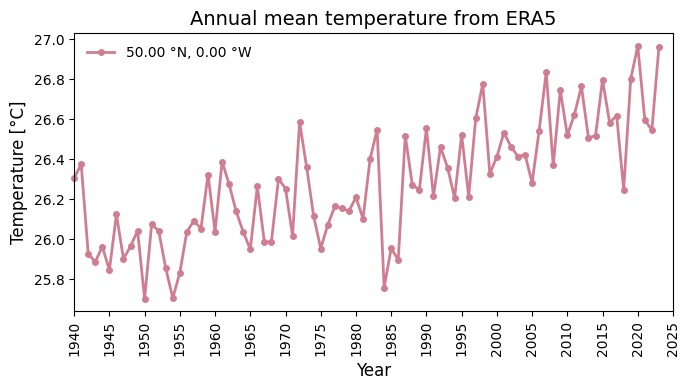

In [9]:
# Make the plot
lw = 2
marker = 'o'
markersize = 4

latSuffix = 'N' if lat > 0 else 'S'
lngSuffix = 'E' if lng > 0 else 'W'

# Create a new figure
plt.figure(figsize=(7, 4))

# Plot the data
plt.plot(years1, ts1, marker=marker, markersize=markersize, label=f'{abs(lat):.2f} °{latSuffix:s}, {abs(lng):.2f} °{lngSuffix:s}', color='#CF7E92', lw=lw, clip_on=False)

# Add legend
plt.legend(framealpha=0)

# Set x-ticks to appear every 10 years and rotate them
plt.xticks(np.arange(1940, 2026, 5), rotation=90)
plt.xlim(1940, 2025)

# Customize x and y axis labels
plt.xlabel('Year', fontsize=12)
plt.ylabel('Temperature [°C]', fontsize=12)

# Add title with custom font
plt.title('Annual mean temperature from {:s}'.format(ERA_VERSION), fontsize=14)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()